# Importing essential libraries 

In [90]:
import pandas as pd

# Reading the sample data

In [91]:
trans_data = pd.read_csv('Data_Files\\Synthetic_Data_3b.csv')


# Detecting Circular Transactions

In [92]:

# Initially all the transactions are suspicious
suspect_trans = trans_data

# Variable to keep track of change in number of suspicious transactions
change = 1
flag = 1    #Keeps track of number of iterations

# Empty variable to store circular transaction
circular_trans = []

# Iterate till the number of suspicious and circular transactions are same
while not change == 0:
    circular_trans = []
    
    # Print iterations and number of suspicious transaction at every iteration
    print("Iteration : ",flag,", No. of suspicious transactions : ",len(suspect_trans))
    
    # Checking whether the buyers are also the sellers
    is_seller = suspect_trans['SellerID'].isin(suspect_trans['BuyerID'].unique())
    circular_trans.extend(suspect_trans[is_seller]['TransactionID'])
    
    change = len(suspect_trans) - len(circular_trans)
    
    # Now all the circular transactions are suspicious
    suspect_trans = suspect_trans.loc[suspect_trans['TransactionID'].isin(circular_trans)]  
    suspect_trans.reset_index(drop=True, inplace=True)
    flag += 1
    
# Testing in inverse manner
change = 1
while not change == 0:
    circular_trans = []
    print("Iteration : ",flag,", No. of suspicious transactions : ",len(suspect_trans))
    is_buyer = suspect_trans['BuyerID'].isin(suspect_trans['SellerID'].unique())
    circular_trans.extend(suspect_trans[is_buyer]['TransactionID'])
    change = len(suspect_trans) - len(circular_trans)
    suspect_trans = suspect_trans.loc[suspect_trans['TransactionID'].isin(circular_trans)]  
    suspect_trans.reset_index(drop=True, inplace=True)
    flag += 1

# Now we have the list of transactions that can make the loop
circular_trans = suspect_trans

Iteration :  1 , No. of suspicious transactions :  7500
Iteration :  2 , No. of suspicious transactions :  4823
Iteration :  3 , No. of suspicious transactions :  3618
Iteration :  4 , No. of suspicious transactions :  2912
Iteration :  5 , No. of suspicious transactions :  2446
Iteration :  6 , No. of suspicious transactions :  2143
Iteration :  7 , No. of suspicious transactions :  1925
Iteration :  8 , No. of suspicious transactions :  1745
Iteration :  9 , No. of suspicious transactions :  1601
Iteration :  10 , No. of suspicious transactions :  1480
Iteration :  11 , No. of suspicious transactions :  1390
Iteration :  12 , No. of suspicious transactions :  1293
Iteration :  13 , No. of suspicious transactions :  1218
Iteration :  14 , No. of suspicious transactions :  1173
Iteration :  15 , No. of suspicious transactions :  1131
Iteration :  16 , No. of suspicious transactions :  1086
Iteration :  17 , No. of suspicious transactions :  1057
Iteration :  18 , No. of suspicious tran

# A look at the circular transactions

In [93]:
circular_trans

,TransactionID,BuyerID,SellerID,Amount(INR),Date
0,5,A1ZS,X7V9,176881,2022-02-24
1,35,WXK1,INC6,341276,2022-02-10
2,185,KWC1,MOB0,88278,2022-03-13
3,271,8UOX,D8JT,978440,2022-01-11
4,398,X6B8,IRXP,141735,2022-03-04
...,...,...,...,...,...
73,7040,W1RR,5C81,839039,2022-03-07
74,7122,K2EO,W1RR,762645,2022-01-14
75,7438,S56P,HKNG,247590,2022-02-24
76,7444,D1IU,EA5I,348500,2022-02-17


# Lets plot and see in the directed graphs

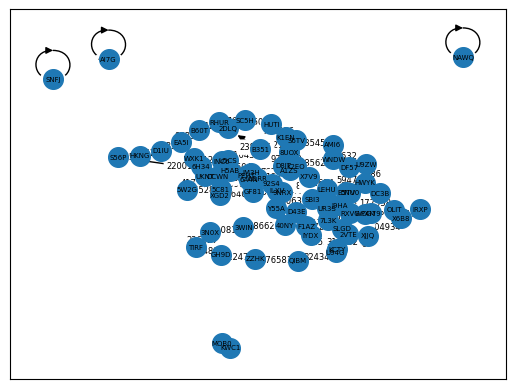

In [114]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def generate_multidirected_graph_image(trades_df):
    # Create a multidigraph using NetworkX
    graph = nx.DiGraph()
    for i, row in trades_df.iterrows():
        buyer, seller, amount, time = row['BuyerID'], row['SellerID'], row['Amount(INR)'], row['Date']
        if(graph.has_edge(buyer,seller)):
            graph[buyer][seller]['amount']=amount+graph[buyer][seller]['amount']
            continue
        graph.add_edge(buyer, seller, amount=amount)

    # Plot the graph
    #nodes
    G=graph
    pos=nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=200)
    nx.draw_networkx_labels(G, pos, ax=ax,font_size=5)
    #edges
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges)
    arc_rad = 0.3
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')
    #adding labels
    import my_networkx as my_nx
    edge_weights = nx.get_edge_attributes(G,'amount')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=4)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False, font_size=6)
    # fig.savefig("Graph_Visualization.png", bbox_inches='tight',pad_inches=0)
    plt.show()


# Load the trades data into a pandas DataFrame
trades_df = circular_trans

# Call the generate_multidirected_graph_image function
generate_multidirected_graph_image(trades_df)
